# Parameter optimization

### Get the data already preprocessed

- `poly_data` and `poly_names` from [polynomial_features](polynomial_features.ipynb)
- `vector_data` and `vector_names` from [save_email_features](save_email_features.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

HOME_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME_PATH, 'Desktop', 'raw_data', 'ml')

poly_path = os.path.join(DATA_PATH, 'poly_data.pkl')
poly_names_path = os.path.join(DATA_PATH, 'poly_names.pkl')
with open(poly_path, 'rb') as f:
    poly_data = pickle.load(f)
with open(poly_names_path, 'rb') as f:
    poly_names = pickle.load(f)
    
vector_path = os.path.join(DATA_PATH, 'vector_data.pkl')
vector_names_path = os.path.join(DATA_PATH, 'vector_names.pkl')

with open(vector_path, 'rb') as f:
    vector_data = pickle.load(f)
with open(vector_names_path, 'rb') as f:
    vector_names = pickle.load(f)

Merge dictionaries and feature lists

In [2]:
from copy import deepcopy
final_data = deepcopy(poly_data)
for key, item in final_data.items():
    item.update(vector_data[key])
    
print 'inner keys:', len(final_data['METTS MARK'].keys()),\
      'compare:', len(vector_data['METTS MARK'].keys()) + len(poly_data['METTS MARK'].keys()) - 1

inner keys: 4290 compare: 4290


In [2]:
from copy import deepcopy
final_data = deepcopy(poly_data)
for key, item in final_data.items():
    item.update(vector_data[key])
    
print 'inner keys:', len(final_data['METTS MARK'].keys()),\
      'compare:', len(vector_data['METTS MARK'].keys()) + len(poly_data['METTS MARK'].keys()) - 1

vector_names.remove('poi')
final_names = poly_names + vector_names
print 'Features:', len(final_names), 'compare:', len(final_data['METTS MARK'].keys())

inner keys: 4290 compare: 4290
Features: 4290 compare: 4290


Convert data to a usable array

In [4]:
from tools.feature_format import featureFormat

array = featureFormat(final_data, final_names,
                      keep_keys=True, remove_NaN=True, remove_all_zeroes=False)
keys, labels, features =\
        array[:,0], array[:,1].astype(np.float16), array[:, 2:].astype(np.float32)

print 'Keys, labels, features shapes:', keys.shape, labels.shape, features.shape

Keys, labels, features shapes: (148,) (148,) (148, 4289)


In [13]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels =\
train_test_split(features, labels, test_size=0.4, random_state=42)

### Test on different classifiers

In [18]:
#Scoring function
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report

def score_display(clf, features, labels, title):
    print title, ':\n'
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=41)
    for scoring in ['recall', 'precision', 'f1']:
        scores = cross_val_score(pipe, features, labels, cv=cv, scoring=scoring)
        mean, std = np.mean(scores), np.std(scores)
        print '-', scoring, scores
        print 'Mean: %0.2f (+/-%0.2f)' % (mean, 2*std)

In [19]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
score_display(clf, features, labels, 'Naive-Bayes')

Naive-Bayes :

- recall [ 0.25        0.14285714  0.28571429]
Mean: 0.23 (+/-0.12)
- precision [ 0.4  1.   1. ]
Mean: 0.80 (+/-0.57)
- f1 [ 0.30769231  0.25        0.44444444]
Mean: 0.33 (+/-0.16)


In [8]:
### Try a variety of classifiers
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

params = {'estimator': [SVC(), 
                        AdaBoostClassifier(),
                        ExtraTreesClassifier(),
                        RandomForestClassifier(),
                        LogisticRegression()]
         }

grid = GridSearchCV(pipe, param_grid=params,
                    cv=15, verbose=1,
                    n_jobs=-1, scoring='f1')


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid.fit(features, labels)
    
print grid.best_params_
print grid.best_score_

Fitting 15 folds for each of 5 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.0s finished


{'estimator': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)}
0.222222222222


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, chi2


pipe = Pipeline([
                 ('scaler', StandardScaler()),
                 #('polynomials', PolynomialFeatures(2)),
                 #('feature_selr', SelectPercentile(chi2)),
                 ('estimator', GaussianNB())
                ])

In [9]:
best = find_top_scores(grid, 5, 15)

<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
0.222222222222 0.378430808132
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
0.2 0.4
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.144444444444 0.303477784083
<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
0.133333333333 0.33993463424
<class 'sklearn.svm.classes.SVC'>
0.0 0.0


In [10]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(class_weight='balanced', random_state=42)
ABC = AdaBoostClassifier(base_estimator=DTC, random_state=42)
ABC_params = {'polynomials__degree': [2,3],
              'estimator': [ABC],
              'estimator__base_estimator__max_depth': [None, 3, 6, 12, 24, 48],
              'estimator__base_estimator__min_samples_leaf': [1, 2, 4, 8, 16],
              'estimator__n_estimators': [25, 50, 100, 250],
              'estimator__learning_rate': [0.01, 0.1, 1, 10]}

ETC = ExtraTreesClassifier(class_weight='balanced', random_state=42)
ETC_params = {'polynomials__degree': [2,3],
              'estimator': [ETC],
              'estimator__max_depth': [None, 3, 6, 12, 24, 48],
              'estimator__min_samples_leaf': [1, 2, 4, 8, 16],
              'estimator__n_estimators': [25, 50, 100],
              'estimator__max_features': [1, 2, 4, 6, 8, 10]}

RF = RandomForestClassifier(class_weight='balanced', random_state=42)
RF_params = {'polynomials__degree': [2,3],
             'estimator': [RF],
             'estimator__max_depth': [None, 3, 6, 12, 24, 48],
             'estimator__min_samples_leaf': [1, 2, 4, 8, 16],
             'estimator__n_estimators': [25, 50, 100],
             'estimator__max_features': [1, 2, 4, 6, 8, 10]}

LR = LogisticRegression(solver='lbfgs')
LR_params = {'polynomials__degree': [2,3],
             'estimator': [LR],
             'estimator__C': [1e-2, 1e-1, 1, 1e1, 1e2],
             'estimator__class_weight': [None, 'balanced'],
             'estimator__max_iter': [100, 200],
             'estimator__tol': [1e-4, 5e-4, 1e-3],
             'estimator__warm_start': [False, True]}

large_grid_params = [ABC_params, ETC_params, RF_params, LR_params]

---

### No need to run the 2 cells below again! 
(Relevant data has been pickled in large_grid.pkl

---

In [44]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    large_grid = GridSearchCV(pipe,
                              param_grid=large_grid_params,
                              cv=5, 
                              verbose=1,
                              n_jobs=-1,
                              scoring='f1')

    large_grid.fit(features, labels)

Fitting 5 folds for each of 3360 candidates, totalling 16800 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 326 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1926 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 3326 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 4176 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 5126 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 6176 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 7326 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 8576 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 9926 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 11376 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 12926 tasks      | elapsed: 44

In [46]:
with open('large_grid.pkl', 'wb') as f:
    pickle.dump(large_grid, f)

---
Run from here on to catch up

---

In [11]:
import pickle
with open('large_grid.pkl', 'rb') as f:
    large_grid = pickle.load(f)

In [95]:
def find_top_scores(grid, class_types, cutoff=5, cv=5, verbose=False):
    """
    List the top scores from a fitted gridCV search
    
    returns list of tuples with (rank, estimator_label, test_scores, real index)
    """

    grid_results = grid.cv_results_

    score_keys = []
    end_str = '_test_score'
    start_str = 'split'
    for num in range(cv):
        complete_str = start_str+str(num)+end_str
        score_keys.append(complete_str)

    ranks = grid_results['rank_test_score']
    names_scores = []
    
    for rank in range(1,cutoff+1):
        
        idx_list = np.where(ranks == rank)[0]
        # More than one estimator can have the same rank
        for i in idx_list:
            estimator = grid_results['params'][i]['estimator']
            for tup in class_types:
                if isinstance(estimator, tup[0]):
                    estimator_label = tup[1]
            test_scores = []
            for key in score_keys:
                test_scores.append(grid_results[key][i])
            
            if verbose:
                print(estimator_label)
                print np.mean(test_scores), np.std(test_scores)
            
            names_scores.append((rank, estimator_label, test_scores, i))
    
    return names_scores

In [96]:
class_types = [(AdaBoostClassifier, 'AdaBoost'),
               (ExtraTreesClassifier, 'ExtraTrees'),
               (RandomForestClassifier, 'RandomForest'),
               (LogisticRegression, 'LogisticRegression')]

top200 = find_top_scores(large_grid, class_types, cutoff=200)

In [84]:
import matplotlib.patches as mpatches

def plot_scores(score_list):
    """
    plots scores from score_list generated by find_top_scores
    
    score_list should be a list of tuples in the form:
    tup[0] = rank
    tup[1] = estimator label string
    tup[2] = list of scores
    tup[3] = real_index
    """
    
    ranks = [tup[0] for tup in score_list]
    labels = [tup[1] for tup in score_list]
    scores = [tup[2] for tup in score_list]
    means = [np.mean(x) for x in scores]
    stds = [np.std(x) for x in scores]
    
    plt.close('all')
    ind = len(score_list)
    fig = plt.figure(1, figsize=(10, 7), tight_layout=True)
    ax = fig.gca(title='Estimator scores',
                 xlabel='Rank',
                 xlim=[-1, ind],
                 xticks=range(ind),
                 ylabel='average score')
    bar_list = ax.bar(range(ind), means, yerr=stds, align='center')
    ax.set_xticklabels(ranks)
    # color bar based on label selected features red
    color_dict = {'AdaBoost': 'b',
                  'ExtraTrees': 'r',
                  'RandomForest': 'g',
                  'LogisticRegression': 'm'}
    for i, name in enumerate(labels):
        bar_list[i].set_color(color_dict[name])
        
    # create custom legend
    blue_patch = mpatches.Patch(color='blue', label='Adaboost')
    red_patch = mpatches.Patch(color='red', label='ExtraTrees')
    green_patch = mpatches.Patch(color='green', label='RandomForest')
    magenta_patch = mpatches.Patch(color='magenta', label='LogisticRegression')
    plt.legend(handles=[blue_patch, red_patch, green_patch, magenta_patch])
    plt.show()

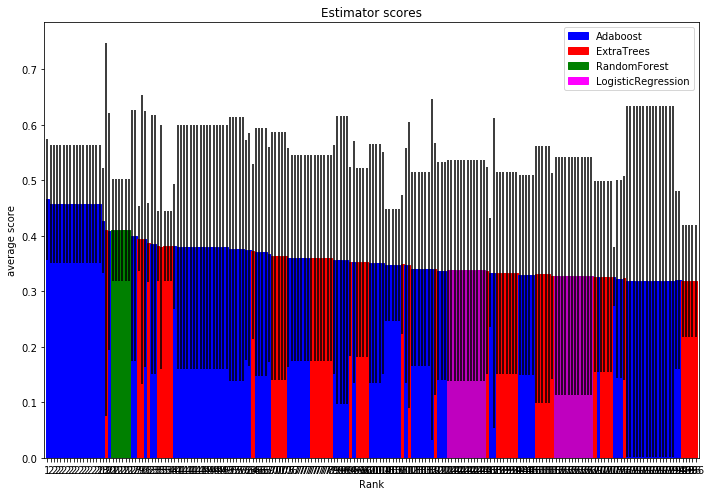

In [98]:
plot_scores(top200)

In [92]:
from scipy.stats import variation

def rank_by_cv(score_list):
    """
    sorts score list by coefficient of variation
    
    score_list should be a list of tuples in the form:
    tup[0] = rank
    tup[1] = estimator label string
    tup[2] = list of scores
    tup[3] = real_index
    """
    ranks = [tup[0] for tup in score_list]
    labels = [tup[1] for tup in score_list]
    scores = [tup[2] for tup in score_list]
    real_is = [tup[3] for tup in score_list]
    cvs = [variation(score) for score in scores]
    
    all_list = zip(ranks, labels, scores, real_is, cvs)
    
    all_list = sorted(all_list, key=lambda tup: tup[4])
    all_list = [tup[:4] for tup in all_list]
    
    return all_list

In [99]:
top200[0]

(1,
 'AdaBoost',
 [0.28571428571428575,
  0.40000000000000002,
  0.57142857142857151,
  0.57142857142857151,
  0.5],
 238)

In [100]:
top200_cv = rank_by_cv(top200)

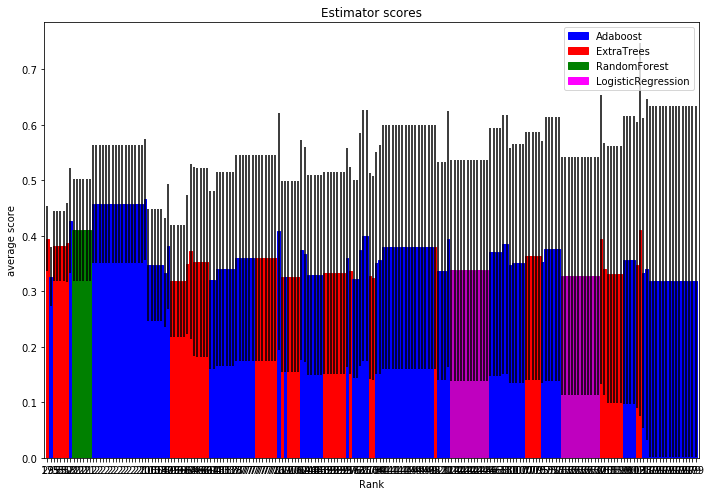

In [101]:
plot_scores(top200_cv)

In [103]:
top200_cv[:5]

[(29,
  'ExtraTrees',
  [0.44444444444444448,
   0.40000000000000002,
   0.44444444444444442,
   0.28571428571428575,
   0.40000000000000002],
  1336),
 (175,
  'AdaBoost',
  [0.25,
   0.40000000000000002,
   0.36363636363636365,
   0.28571428571428575,
   0.33333333333333337],
  313),
 (35,
  'ExtraTrees',
  [0.44444444444444448,
   0.40000000000000002,
   0.44444444444444442,
   0.28571428571428575,
   0.33333333333333331],
  976),
 (35,
  'ExtraTrees',
  [0.44444444444444448,
   0.40000000000000002,
   0.44444444444444442,
   0.28571428571428575,
   0.33333333333333331],
  1516),
 (35,
  'ExtraTrees',
  [0.44444444444444448,
   0.40000000000000002,
   0.44444444444444442,
   0.28571428571428575,
   0.33333333333333331],
  1696)]

In [108]:
idxs = [0, 2, 3, 4]
param_is = [top200_cv[i][3] for i in idxs]
params = [large_grid.cv_results_['params'][i] for i in param_is]

In [122]:
top_keys = params[0].keys()
est_keys = params[0]['estimator'].get_params().keys()
for key in top_keys:
    if key != 'estimator':
        print
        print key
        for item in params:
            print item[key],
    else:
        for key in est_keys:
            print
            print key
            for item in params:
                print item['estimator'].get_params()[key],


estimator__min_samples_leaf
4 4 4 4
polynomials__degree
2 2 2 2
estimator__max_features
1 1 1 1
warm_start
False False False False
oob_score
False False False False
n_jobs
1 1 1 1
verbose
0 0 0 0
max_leaf_nodes
None None None None
bootstrap
False False False False
min_samples_leaf
4 4 4 4
n_estimators
100 100 100 100
min_samples_split
2 2 2 2
min_weight_fraction_leaf
0.0 0.0 0.0 0.0
criterion
gini gini gini gini
random_state
42 42 42 42
min_impurity_split
1e-07 1e-07 1e-07 1e-07
max_features
1 1 1 1
max_depth
6 None 12 24
class_weight
balanced balanced balanced balanced
estimator__max_depth
6 None 12 24
estimator__n_estimators
100 100 100 100


The only parameter changing is `estimator__max_depth` and in that one 6, 12, and 24 seem to give the same result (based on scores reported two cell up). I will pursue the 1st one:

In [124]:
param_is[0]

1336

In [125]:
params_to_test = large_grid.cv_results_['params'][1336]

In [126]:
with open('testing_params.pickle', 'wb') as f:
    pickle.dump(params_to_test, f)